# Twitter Sentiment Analysis

### Installing Dependencies

In [6]:
import numpy as np
import pandas as pd

import re
import emoji
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS

# Warning
import warnings
warnings.filterwarnings("ignore")

# Visualization Library
import matplotlib.pyplot as plt
import seaborn as sns

# Language Library
from langdetect import detect
from google_trans_new import google_translator

In [3]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# nltk.download('all')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

stopwords_list = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shyam29111/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/shyam29111/nltk_data...
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shyam29111/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shyam29111/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Loading Dataset

In [7]:
# Loading the dataset
df = pd.read_csv("dataset.csv")

### Exploratory Data Analysis

In [8]:
# Printing first 10 rows
df.head(10)

,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
1,#BadBunny: Como dos gotas de agua: Joven se di...,es,negative
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
5,It sucks for me since I'm focused on the natur...,en,negative
6,@en_font Treballar a l’obra a partir dels 19 a...,ca,negative
7,@ShawnTarloff @itsmieu you can also relate thi...,en,uncertainty
8,Social Security. Constant political crises dis...,en,negative
9,@FilmThePoliceLA A broken rib can puncture a l...,en,negative


In [9]:
# Printing name of columns
df.columns

Index(['Text', 'Language', 'Label'], dtype='object')

In [10]:
# Printing row and column length a.k.a. shape of dataset
df.shape

(937854, 3)

In [11]:
# Printing info of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937854 entries, 0 to 937853
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Text      937854 non-null  object
 1   Language  937831 non-null  object
 2   Label     937854 non-null  object
dtypes: object(3)
memory usage: 21.5+ MB


In [12]:
# Printing number of unique rows
df['Text'].nunique()

929544

In [13]:
df = df.head(50000)

### Data Visualization of Target Variables

In [14]:
texts = df['Text']
text_len = [len(t.split()) for t in texts.values]
len_mean = np.mean(text_len)
len_mean

np.float64(25.72852)

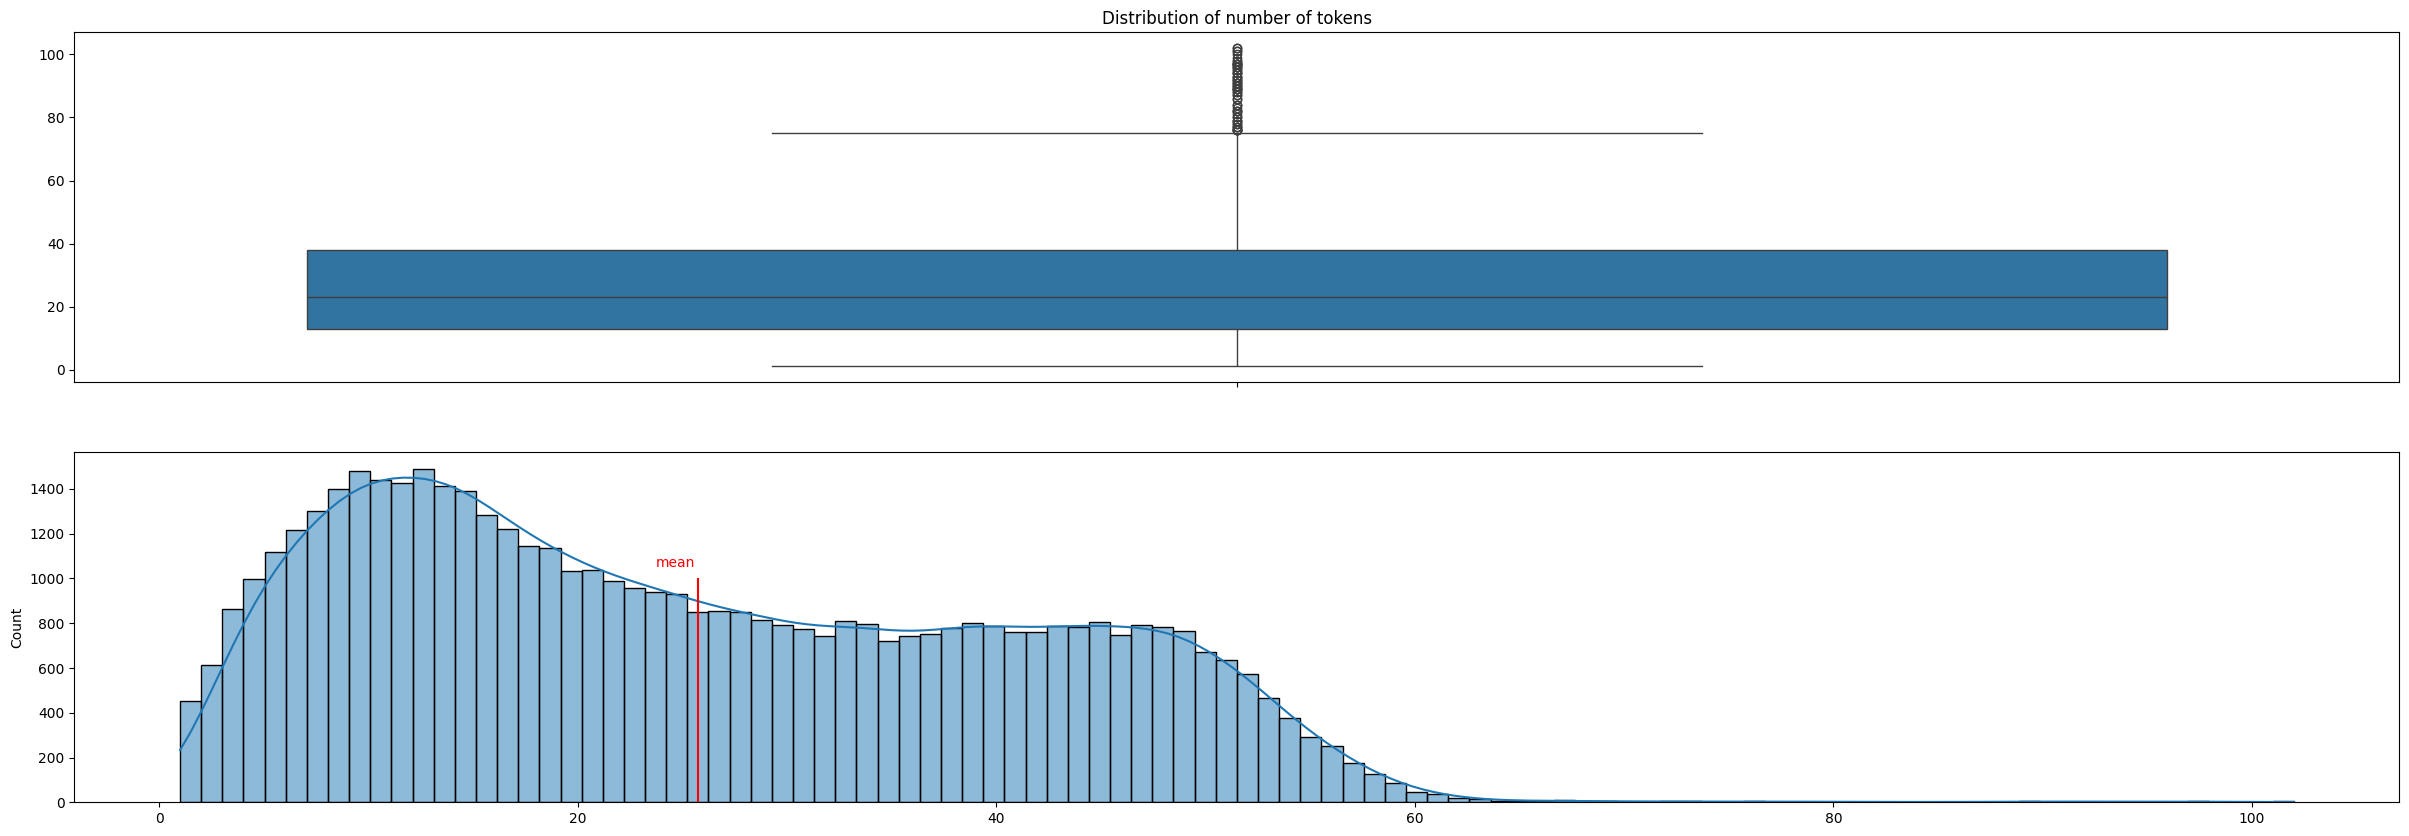

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(30, 10))
axes[0].set_title('Distribution of number of tokens')
sns.boxplot(text_len, ax=axes[0])
sns.histplot(text_len, bins=100, kde=True, ax=axes[1])
axes[1].vlines(len_mean, 0, 1000, color = 'r')
plt.annotate("mean", xy=(len_mean, 1500), xytext=(len_mean-2, 1050), color='r')
plt.show()

Mean length of tweets is nearly 26 tokens. 
The distribution is scewed positively and a few outliers are observed on the right tail. Some of them are clode to the right whisker but some are located far from the majority of points.

In [16]:
extreme_outliers = df['Text'][np.array(text_len) > 60]

for idx in extreme_outliers.index:
    print(idx, 'Target', df['Label'][idx])
    print(extreme_outliers[idx])
    print('=-=-=-=-=-=-=-=-'*4, '\n')

590 Target litigious
@Vickie627 @FreeAsFuck45 @MJB24681 @TomDoubting @NathanBronson7 @Bigteethyouhave @HungWang10 @ziggywilde @Jaxonmedic @QuidRises @max____headroom @Flattielover @Karate61 @newsjunky2 @VinceGottalotta @KsLiberal @jerbear714 @2020_re_VISION @DocDeezWhat @SuP3rK @Synyster63 @dirk_fasshauer @Sembrouthes @NanetteDonnelly @RushvilleRockit @PeterBartholo14 @KSfirefly24 @Jesus_is_G_d @PalusoSonny @FIyFisherman @giddy_bunny @mmEyeNewMe @SouthTownKing @jdd2169 @AngryFleas @skeeduu @PhilipEMSkinne1 @IamTheRealDrD @MomoMight @Jeanelynn @MiddleMolly @shelly_laughing @LadyOfTheOcean1 @Saggit95 @Joe__312 @KidGuacamole @jl28r1 @chriscr66024638 @EdBlackEsq @GuinnBonnie "Simply put, the National Guard only shows up to D.C. when they’ve been invited, and the Capitol Police did not extend that invitation until after the breach, according to a source with knowledge of the process, who was not authorized to speak about it on the record."
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

###### Target Analysis

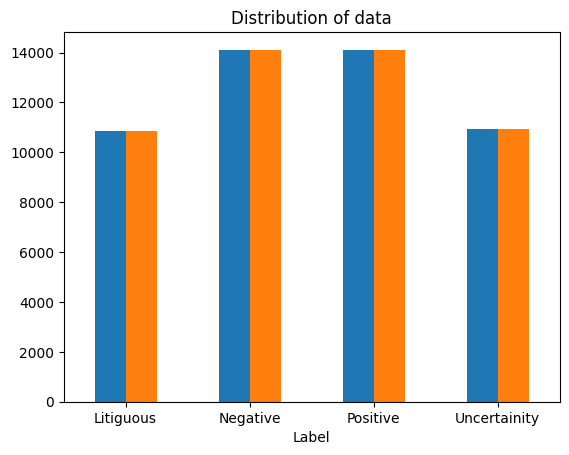

In [17]:
# Plotting the distribution for dataset.
ax = df.groupby('Label').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Litiguous','Negative','Positive','Uncertainity'], rotation=0)

# Storing data in lists.
text, sentiment = list(df['Text']), list(df['Label'])

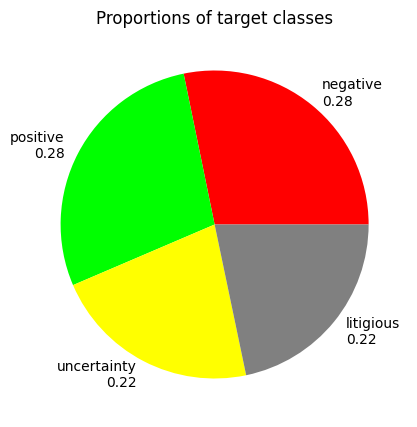

In [18]:
# balance
target_balance = df['Label'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(target_balance, labels=[f'{idx}\n{round(target_balance[idx]/len(df), 2)}' for idx in target_balance.index], colors=['r', '#00FF00', '#FFFF00', 'gray'])
plt.title('Proportions of target classes')
plt.show()

Target categories are almost of equal size, so resampling is not required.

In [19]:
# top words
word_counts = {'litigious': [], 'positive': [], 'negative': [], 'uncertainty': []}
pattern = re.compile('[^\w ]')
for text, t in zip(df['Text'], df['Label']):
    text = re.sub(pattern, '', text).lower().split()
    text = [word for word in text if word not in stopwords_list]
    word_counts[t].extend(text)

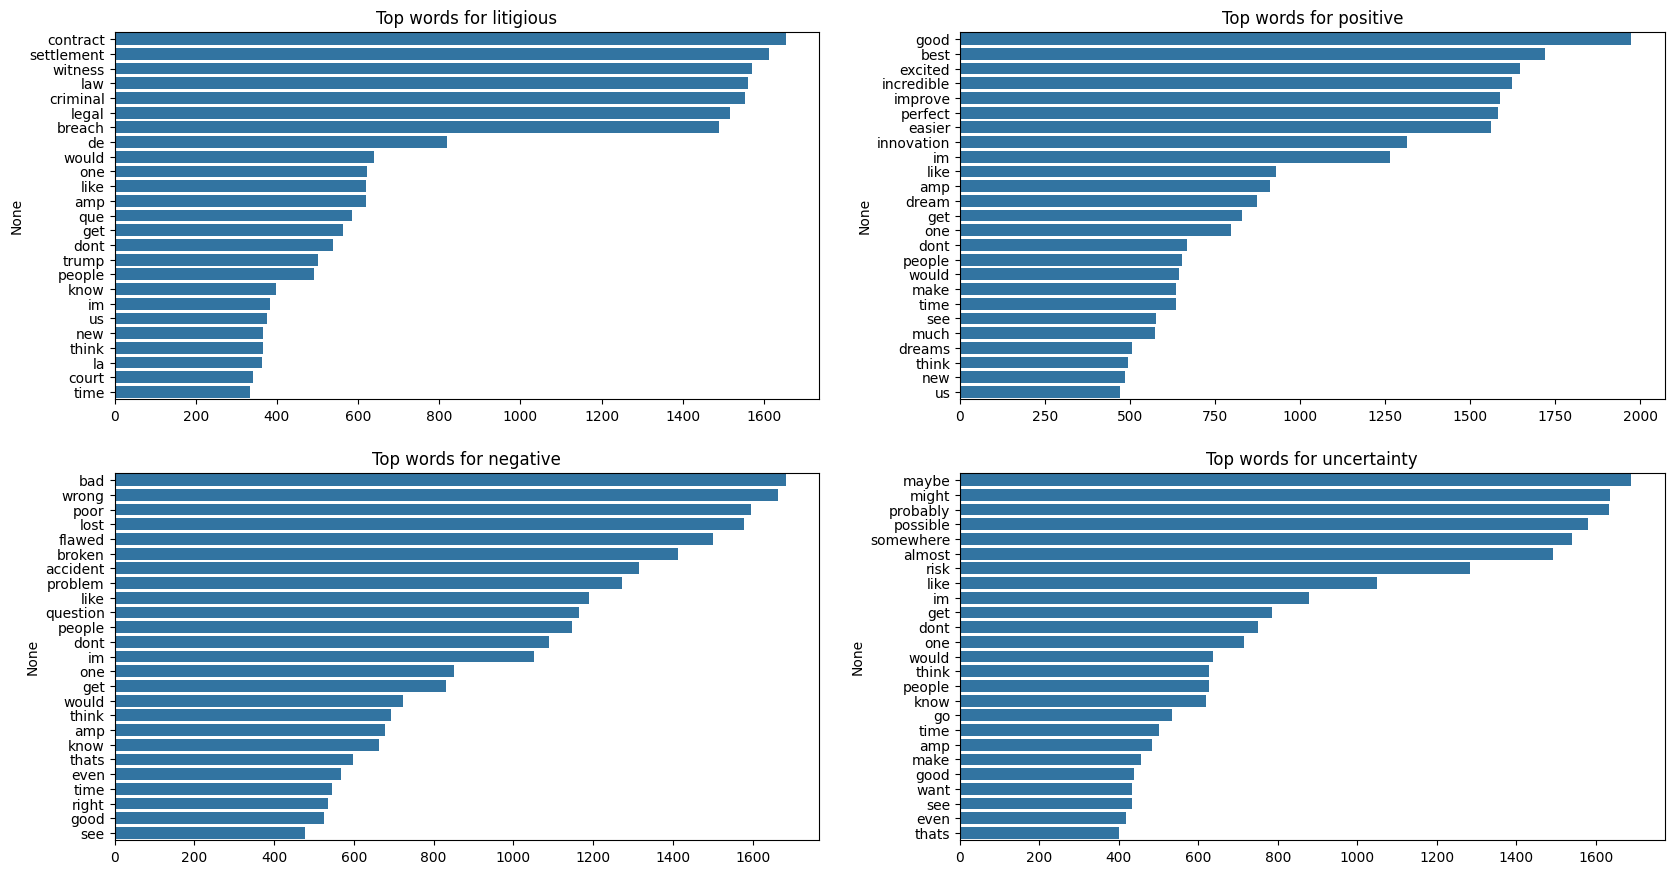

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {target}')
plt.show()

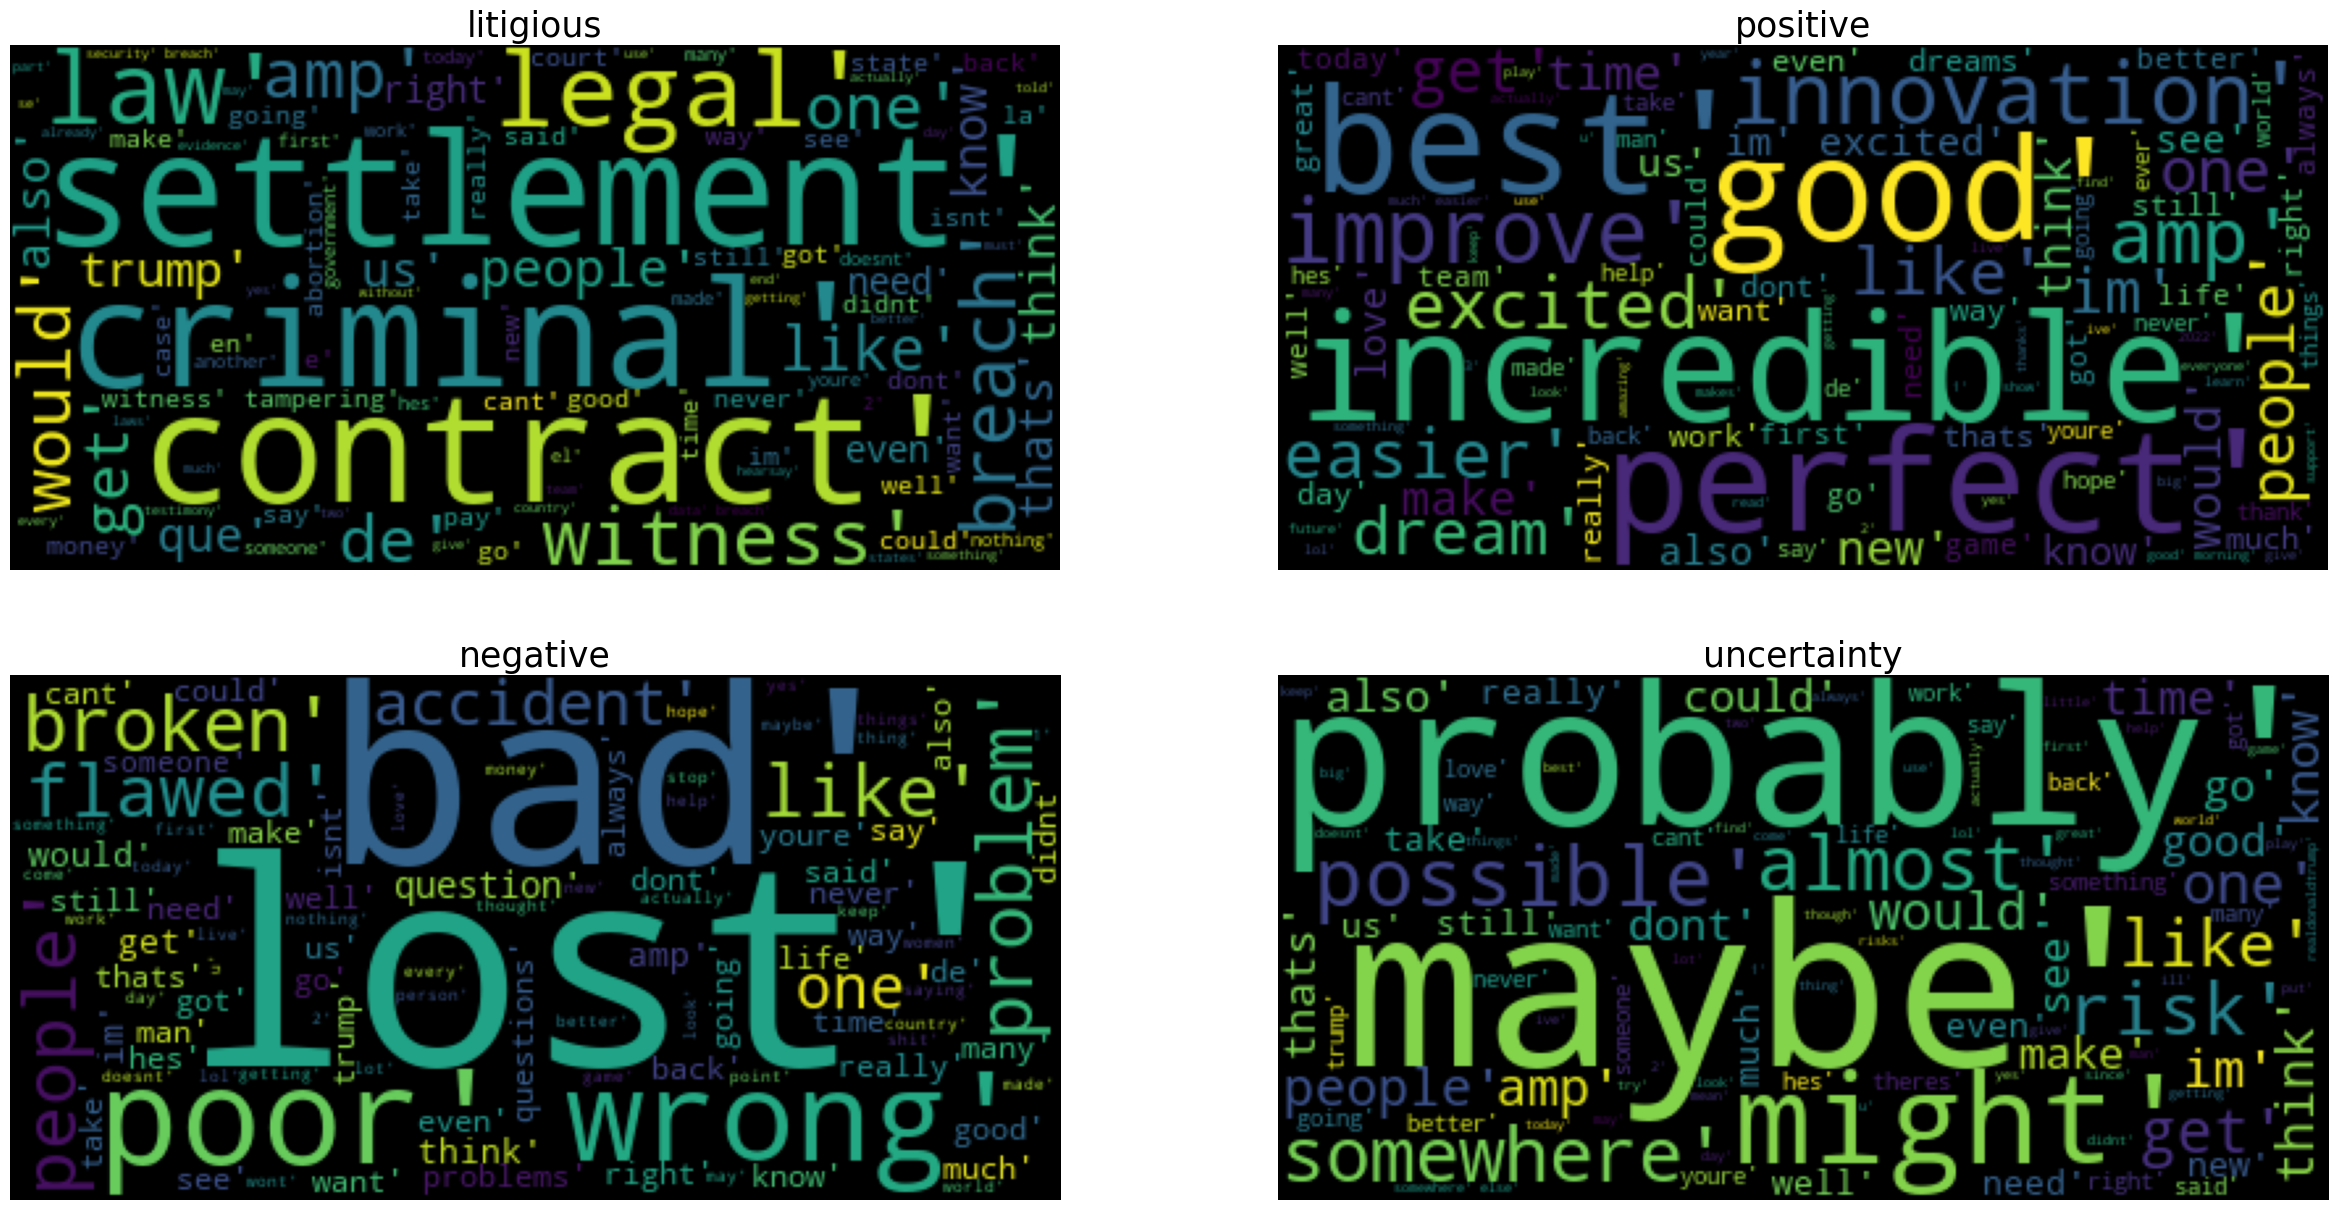

In [21]:
stops = set(STOPWORDS)
fig, axes = plt.subplots(2, 2, figsize=(30,15)) 
for ax, (target, words) in zip(axes.flatten(), word_counts.items()):
    wordcloud = WordCloud(background_color='black', stopwords=stops, max_words=100).generate(str(words))
    ax.set_title(target, fontsize=25)
    ax.imshow(wordcloud, interpolation="hamming")
    ax.axis('off') 
plt.show()

We can see there is a clear difference between litigious and uncertainty topics.

In "Positive", we can see some positive words, like good, incredible, perfect.

In "Negative", we observe lots of swear words, like poor, wrong, bad. 

In "Litigious" categories, words with contentious connotation are observed like law, settlement, breach, etc. 

To sum up, distribution of top-frequent words are different across target categories.

###### Now, lets see most correlated words for each topic using chi2.

In [22]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english', max_features=10000)
features = tfidf.fit_transform(df['Text']).toarray()
labels = df['Label']

print("Each of the %d Text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 50000 Text is represented by 10000 features (TF-IDF score of unigrams and bigrams)


In [27]:
N = 10
for label in set(labels):
    features_chi2 = chi2(features, labels == label)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(label))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> negative:
  * Most Correlated Unigrams are: questions, question, problem, flawed, bad, accident, broken, lost, wrong, poor
  * Most Correlated Bigrams are: lost https, ve lost, broken https, poor people, question https, feel bad, answer question, car accident, wrong https, bad https

==> positive:
  * Most Correlated Unigrams are: dreams, good, dream, innovation, improve, best, easier, incredible, perfect, excited
  * Most Correlated Bigrams are: good luck, dream https, make easier, innovation https, perfect https, incredible https, sweet dreams, excited https, im excited, good morning

==> litigious:
  * Most Correlated Unigrams are: criminal__x, que, tampering, law, legal, breach, settlement, contract, criminal, witness
  * Most Correlated Bigrams are: surprise witness, law enforcement, year contract, criminal https, contract https, settlement https, breach https, data breach, security breach, witness tampering

==> uncertainty:
  * Most Correlated Unigrams are: perfect, incredi

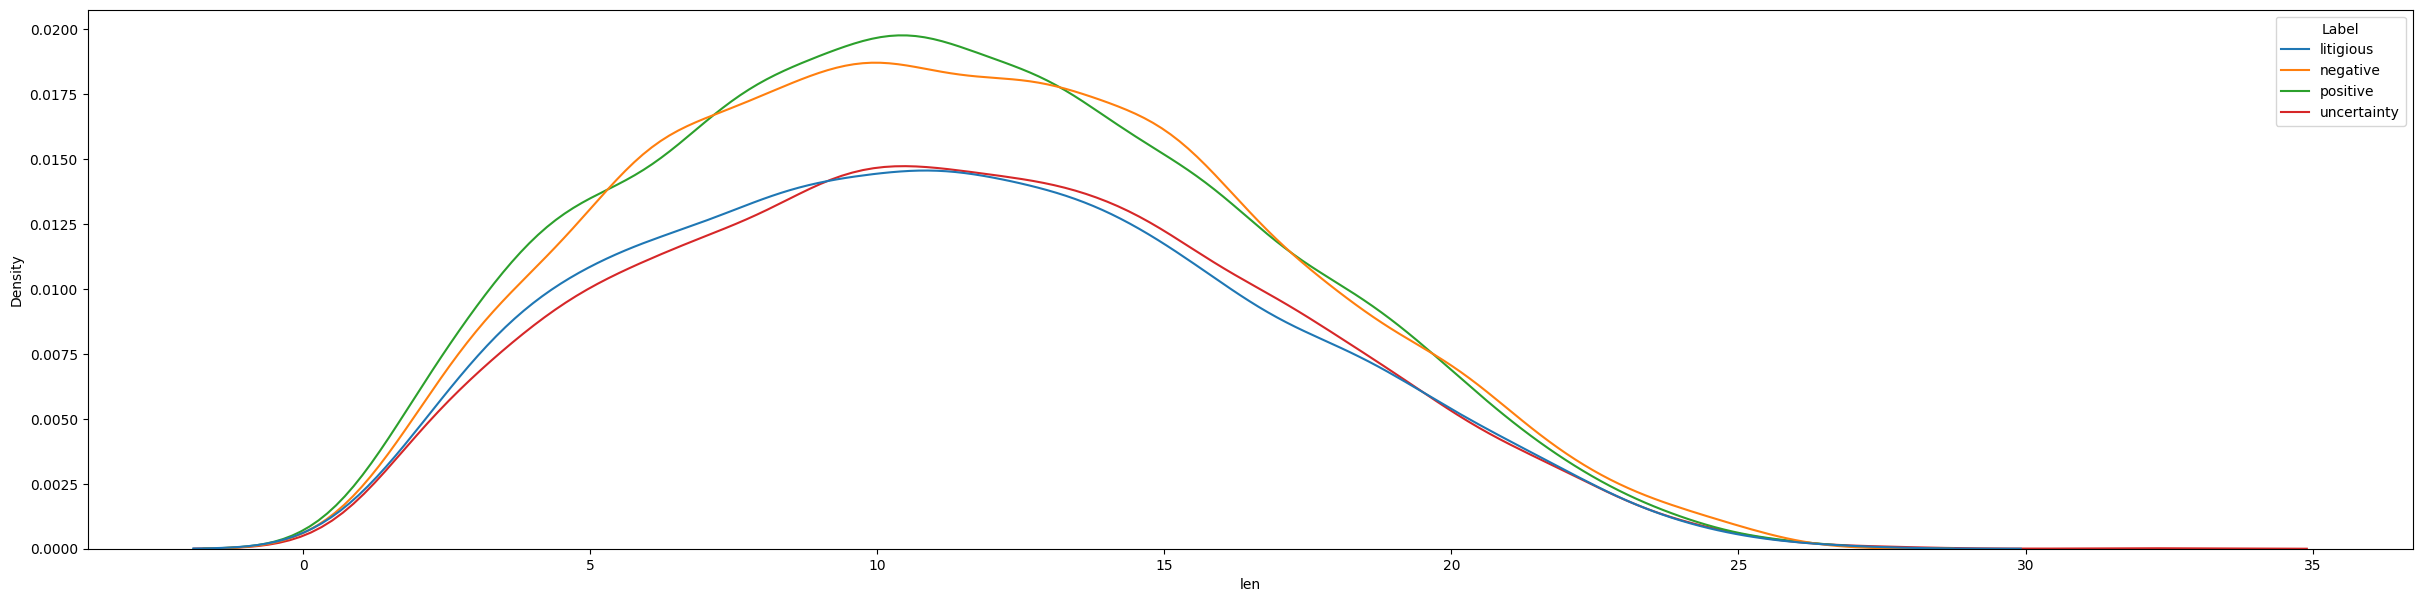

In [28]:
# len for classes without outliers
tweets_len = {'litigious': [], 'positive': [], 'negative': [], 'uncertainty': []}
pattern = re.compile('[^\w ]')
tweets_len = pd.DataFrame([len(re.sub(pattern, '', text).lower().split()) for text in df['Text'] if len(text)< 125], columns=['len'])
tweets_len['Label'] = df['Label']

plt.figure(figsize=(30, 7))
sns.kdeplot(data=tweets_len, x='len', hue='Label')
plt.show()

### Data Preprocessing

In [29]:
# Remove rows with any language other than en or empty columns
df_filtered = df[df['Language'] == 'en']
df_filtered.shape

(46498, 3)

In [30]:
# # Detecting and translating text in english
# def detect_and_translate(df):
#     for index, row in df.iterrows():    
#         if row['Language'] == 'en':
#             continue
#         else:    
#             text = row['Text']
#             lang = row['Language'] 
#             if lang == '':
#                 lang = detect(text)   
#             translator = google_translator()
#             time.sleep(5)
#             translate_text = translator.translate(text,lang_src=lang,lang_tgt='en')      
#             row['Text'] = translate_text
#             row['Language'] = lang
# df_lang = detect_and_translate(df)

### Challenge: Emojis

Two ways to handle emojis and emoticons
1. Decoding emojis to text
2. Removing emojis

##### Decoding Emojis using emoji library

In [31]:
# Decoding Emojis
df_emoji = df_filtered.drop(['Language'], axis=1)

def decode_emojis(texts):
    return [emoji.demojize(text, language='en') for text in texts]

df_emoji['Clean'] = decode_emojis(df_emoji['Text'])
df_emoji.iloc[14]

Text     🤩 Power back on (1855749):  North VI in Ladysm...
Label                                             negative
Clean    :star-struck: Power back on (1855749):  North ...
Name: 17, dtype: object

In [32]:
df_emoji['Clean'] = decode_emojis(df_emoji['Text'])
df_emoji.iloc[14]

# Lowercasing all the letters
df_emoji['Clean'] = df_emoji.apply(lambda row: row['Clean'].lower(), axis=1)

# Removing mentions
df_emoji['Clean'] = df_emoji.apply(lambda row: re.sub("@[A-Za-z0-9_]+","", row['Clean']),axis=1)

# Removing hashtags
df_emoji['Clean'] = df_emoji.apply(lambda row: re.sub("#[A-Za-z0-9_]+","", row['Clean']),axis=1)

# Removing links
df_emoji['Clean'] = df_emoji.apply(lambda row: re.sub(r"http\S+","", row['Clean']),axis=1)
df_emoji['Clean'] = df_emoji.apply(lambda row: re.sub(r"www.\S+","", row['Clean']),axis=1)

# Removing punctuations
df_emoji['Clean'] = df_emoji.apply(lambda row: re.sub('[()!?]'," ", row['Clean']),axis=1)
df_emoji['Clean'] = df_emoji.apply(lambda row: re.sub('\[.*?\]'," ", row['Clean']),axis=1)

# Filtering non-alphanumeric characters
df_emoji['Clean'] = df_emoji.apply(lambda row: re.sub("[^a-z0-9]"," ", row['Clean']),axis=1)

# Removing Digits
df_emoji['Clean'] = df_emoji.apply(lambda row: re.sub("[^a-z]"," ", row['Clean']),axis=1)

df_emoji.head()

,Text,Label,Clean
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,litigious,testimony is not evidence in a court of la...
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,litigious,flagstar bank discloses a data breach that im...
3,Rwanda is set to host the headquarters of Unit...,positive,rwanda is set to host the headquarters of unit...
4,OOPS. I typed her name incorrectly (today’s br...,litigious,oops i typed her name incorrectly today s br...
5,It sucks for me since I'm focused on the natur...,negative,it sucks for me since i m focused on the natur...


##### Removing Emojis

In [33]:
df = df_filtered.drop(['Language'], axis=1)

# Lowercasing all the letters
df['Clean'] = df.apply(lambda row: row['Text'].lower(), axis=1)

# Removing mentions
df['Clean'] = df.apply(lambda row: re.sub("@[A-Za-z0-9_]+","", row['Clean']),axis=1)

# Removing hashtags
df['Clean'] = df.apply(lambda row: re.sub("#[A-Za-z0-9_]+","", row['Clean']),axis=1)

# Removing links
df['Clean'] = df.apply(lambda row: re.sub(r"http\S+","", row['Clean']),axis=1)
df['Clean'] = df.apply(lambda row: re.sub(r"www.\S+","", row['Clean']),axis=1)

# Removing punctuations
df['Clean'] = df.apply(lambda row: re.sub('[()!?]'," ", row['Clean']),axis=1)
df['Clean'] = df.apply(lambda row: re.sub('\[.*?\]'," ", row['Clean']),axis=1)

# Filtering non-alphanumeric characters
df['Clean'] = df.apply(lambda row: re.sub("[^a-z0-9]"," ", row['Clean']),axis=1)

# Removing Digits
df['Clean'] = df.apply(lambda row: re.sub("[^a-z]"," ", row['Clean']),axis=1)

df.head()

,Text,Label,Clean
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,litigious,testimony is not evidence in a court of la...
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,litigious,flagstar bank discloses a data breach that im...
3,Rwanda is set to host the headquarters of Unit...,positive,rwanda is set to host the headquarters of unit...
4,OOPS. I typed her name incorrectly (today’s br...,litigious,oops i typed her name incorrectly today s br...
5,It sucks for me since I'm focused on the natur...,negative,it sucks for me since i m focused on the natur...


##### Stemming

In [34]:
# Stemming
stemmer = PorterStemmer()
def stem(texts):
    # Word Tokenization
    texts = texts.apply(word_tokenize)
    for i, row in enumerate(texts):
        filtered_words = [stemmer.stem(word) for word in row if not word in stopwords.words()]
        row = " ".join(filtered_words)
        if i % 100 == 0:
            print(f"{i} rows stemmed")
    return texts

# stem(df['Clean'])
# stem(df_emoji['Clean'])

##### Lemmatization

In [35]:
# Lemmatization
lemmtizer = WordNetLemmatizer()
def lemma(texts):
    # Word Tokenization
    texts = texts.apply(word_tokenize)
    for i, row in enumerate(texts):
        filtered_words = [lemmtizer.lemmatize(word) for word in row if not word in stopwords.words()]
        row = " ".join(filtered_words)
        if i % 100 == 0:
            print(f"{i} rows lemmatized")
    return texts

# lemma(df['Clean'])
# lemma(df_emoji['Clean'])

In [36]:
# # One Hot Encoding
# df['Label'] = df['Label'].astype('category')
# df['Label'] = df['Label'].cat.codes

# enc = OneHotEncoder()
# enc_data = pd.DataFrame(enc.fit_transform(df['Label']))
# data = df.join(enc_data)
  
# data.head()

In [37]:
def Encoding(df):
    df['Clean'] = df['Clean'].astype('string')
    df['Label'] = df['Label'].astype('category')
    df['Sentiment'] = df['Label'].factorize()[0]
    
Encoding(df)
Encoding(df_emoji)

### Feature Extraction

<ol>
    <b><i><li>Count Vectorizer</li></i></b>
    <b><i><li>TF-IDF Vectorizer</li></i></b>
</ol>

In [38]:
# Vectorizers
def vectorizers(df):
    
    # Count Vectorizer
    def countVectorize(texts):
        vectorizer = CountVectorizer(lowercase=False, stop_words='english', min_df=10, ngram_range=(1,3))
        fitted_vectorizer = vectorizer.fit_transform(texts)
        return fitted_vectorizer.toarray()
    
    # TF-IDF Vectorizer
    def tfidfVectorize(texts):
        vectorizer = TfidfVectorizer(lowercase=False, stop_words='english', min_df=10, ngram_range=(1,3))
        fitted_vectorizer = vectorizer.fit_transform(texts)
        return fitted_vectorizer.toarray()
    
    x_count = countVectorize(df['Clean'])
    x_tfidf = tfidfVectorize(df['Clean'])
    y = df['Sentiment']
    v = [y, x_count, x_tfidf]
    return v

### Splitting Data into Training and Testing Set

In [39]:
def split(y, x):
    train_size = 0.7
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)
    return [x_train, x_test, y_train, y_test]

### Model Building and Training

<ol>
    <b><i><li>Linear Support Vector Classification</li></i></b>
    <b><i><li>Gaussian Naive Bayes</li></i></b>
    <b><i><li>Logistic Regression</li></i></b>
    <b><i><li>Random Forest Classifier</li></i></b>
</ol>

In [40]:
def models(x_train, x_test, y_train, y_test):
        
    def report(y_test, y_pred):
        accuracy = accuracy_score(y_test, y_pred) * 100
        f1score = f1_score(y_test, y_pred, average='weighted') * 100
        recall = recall_score(y_test, y_pred, average='weighted') * 100
        precision = precision_score(y_test, y_pred, average='weighted') * 100
        print('Recall: %.4f' % recall)
        print('Accuracy: %.4f' % accuracy)
        print('F1-Score: %.4f' % f1score)
        print('Precision: %.4f' % precision)
        
        # Classification Report
        print('\nClassification Report\n')
        print(metrics.classification_report(y_test, y_pred, target_names=['litigious', 'positive', 'negative', 'uncertainty']))
        
        # Confusion Matrix and HeatMap
        cm = metrics.confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(cm/np.sum(cm), index = ['Litigious', 'Positive', 'Negative', 'Uncertainty'], columns = ['Litigious', 'Positive', 'Negative', 'Uncertainty'])
        plt.figure(figsize=(7,5))
        sns.heatmap(cm_df, annot=True, fmt='.2%', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual Values')
        plt.xlabel('Predicted Values')
        plt.show()
        
    print("\nLinear Support Vector Classification")    
    model1 = LinearSVC()
    model1.fit(x_train, y_train)
    y_pred_SVC = model1.predict(x_test)
    report(y_test, y_pred_SVC)
    
    print('\nGaussian Naive Bayes')
    model2 = GaussianNB()
    model2.fit(x_train, y_train)
    y_pred_GNB = model2.predict(x_test)
    report(y_test, y_pred_GNB)

    print("\nLogistic Regression")
    model3 = LogisticRegression(max_iter=200)
    model3.fit(x_train, y_train)
    y_pred_LR = model3.predict(x_test)
    report(y_test, y_pred_LR)
    
    print("\nRandom Forest Classifier")
    model4 = RandomForestClassifier(n_estimators=100)
    model4.fit(x_train, y_train)
    y_pred_RFC = model4.predict(x_test)
    report(y_test, y_pred_RFC)

### Result

##### Removing Emojis


Features Extracted Using Count Vectorizer

Linear Support Vector Classification
Recall: 92.9355
Accuracy: 92.9355
F1-Score: 92.9611
Precision: 92.9976

Classification Report

              precision    recall  f1-score   support

   litigious       0.97      0.96      0.97      1950
    positive       0.94      0.94      0.94      2620
    negative       0.95      0.93      0.94      2599
 uncertainty       0.86      0.88      0.87      2131

    accuracy                           0.93      9300
   macro avg       0.93      0.93      0.93      9300
weighted avg       0.93      0.93      0.93      9300



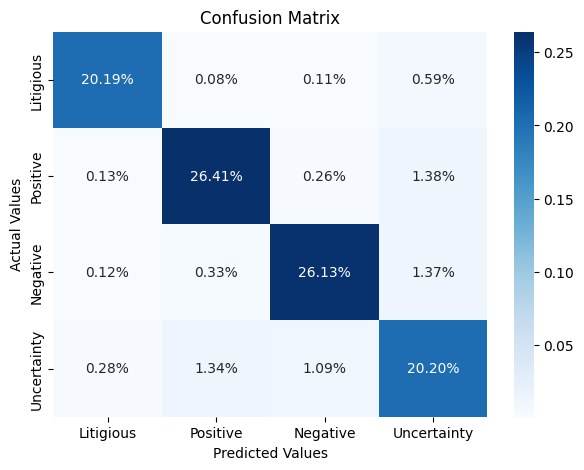


Gaussian Naive Bayes
Recall: 53.3763
Accuracy: 53.3763
F1-Score: 53.3949
Precision: 63.7188

Classification Report

              precision    recall  f1-score   support

   litigious       0.69      0.70      0.69      1950
    positive       0.70      0.42      0.52      2620
    negative       0.77      0.33      0.46      2599
 uncertainty       0.35      0.77      0.49      2131

    accuracy                           0.53      9300
   macro avg       0.63      0.55      0.54      9300
weighted avg       0.64      0.53      0.53      9300



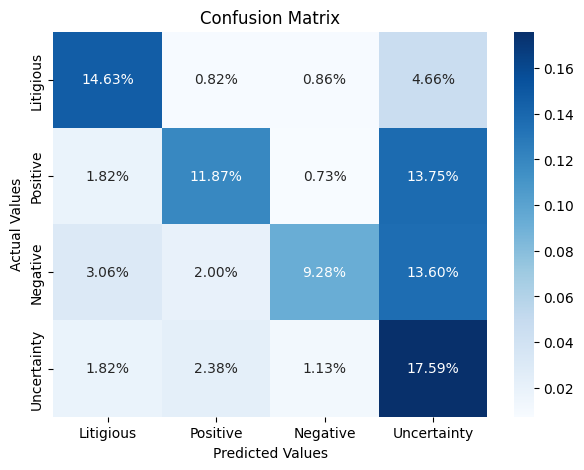


Logistic Regression
Recall: 94.2796
Accuracy: 94.2796
F1-Score: 94.3136
Precision: 94.3768

Classification Report

              precision    recall  f1-score   support

   litigious       0.98      0.96      0.97      1950
    positive       0.95      0.94      0.95      2620
    negative       0.96      0.95      0.95      2599
 uncertainty       0.88      0.92      0.90      2131

    accuracy                           0.94      9300
   macro avg       0.94      0.94      0.94      9300
weighted avg       0.94      0.94      0.94      9300



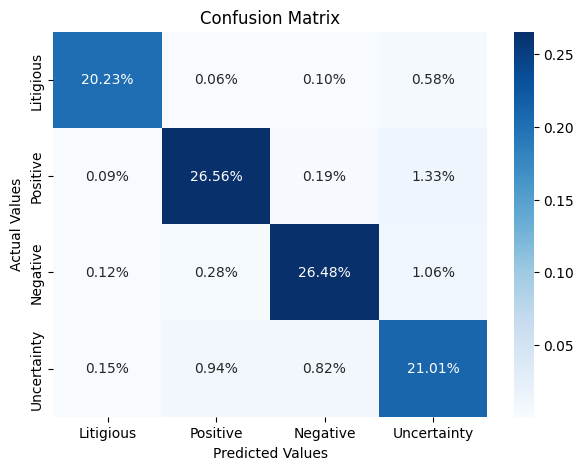


Random Forest Classifier
Recall: 95.0000
Accuracy: 95.0000
F1-Score: 94.9865
Precision: 94.9811

Classification Report

              precision    recall  f1-score   support

   litigious       0.97      0.97      0.97      1950
    positive       0.96      0.96      0.96      2620
    negative       0.96      0.97      0.96      2599
 uncertainty       0.92      0.90      0.91      2131

    accuracy                           0.95      9300
   macro avg       0.95      0.95      0.95      9300
weighted avg       0.95      0.95      0.95      9300



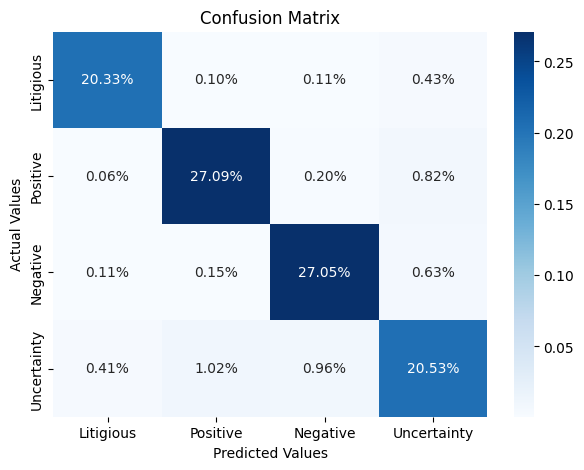



Features Extracted Using Tf-IDF Vectorizer

Linear Support Vector Classification
Recall: 93.9355
Accuracy: 93.9355
F1-Score: 93.9546
Precision: 93.9815

Classification Report

              precision    recall  f1-score   support

   litigious       0.98      0.97      0.97      1950
    positive       0.95      0.94      0.94      2620
    negative       0.95      0.95      0.95      2599
 uncertainty       0.88      0.90      0.89      2131

    accuracy                           0.94      9300
   macro avg       0.94      0.94      0.94      9300
weighted avg       0.94      0.94      0.94      9300



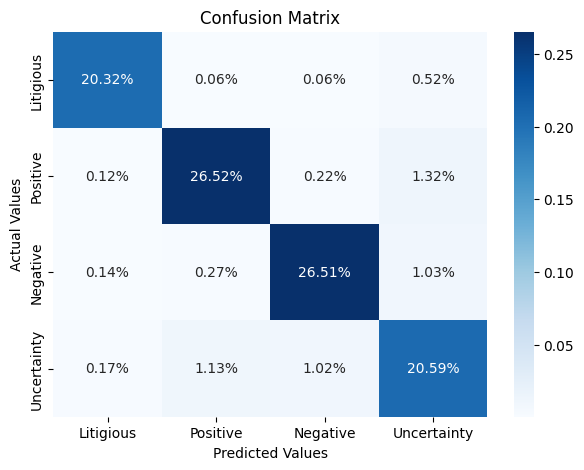


Gaussian Naive Bayes
Recall: 57.1398
Accuracy: 57.1398
F1-Score: 57.2641
Precision: 63.7003

Classification Report

              precision    recall  f1-score   support

   litigious       0.66      0.73      0.69      1950
    positive       0.72      0.54      0.62      2620
    negative       0.74      0.37      0.49      2599
 uncertainty       0.39      0.71      0.50      2131

    accuracy                           0.57      9300
   macro avg       0.63      0.59      0.58      9300
weighted avg       0.64      0.57      0.57      9300



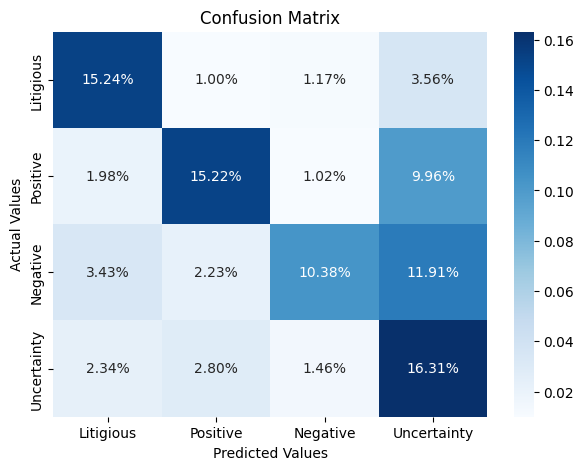


Logistic Regression
Recall: 94.6237
Accuracy: 94.6237
F1-Score: 94.6507
Precision: 94.6998

Classification Report

              precision    recall  f1-score   support

   litigious       0.98      0.96      0.97      1950
    positive       0.95      0.95      0.95      2620
    negative       0.96      0.95      0.96      2599
 uncertainty       0.89      0.92      0.90      2131

    accuracy                           0.95      9300
   macro avg       0.95      0.95      0.95      9300
weighted avg       0.95      0.95      0.95      9300



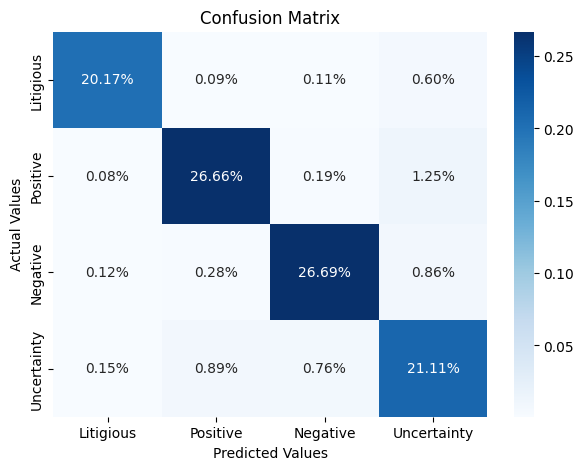


Random Forest Classifier
Recall: 95.1828
Accuracy: 95.1828
F1-Score: 95.1926
Precision: 95.2071

Classification Report

              precision    recall  f1-score   support

   litigious       0.98      0.97      0.97      1950
    positive       0.96      0.95      0.96      2620
    negative       0.96      0.96      0.96      2599
 uncertainty       0.90      0.92      0.91      2131

    accuracy                           0.95      9300
   macro avg       0.95      0.95      0.95      9300
weighted avg       0.95      0.95      0.95      9300



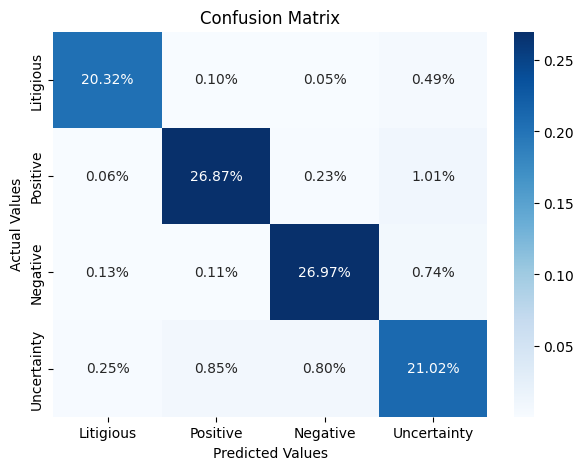

In [41]:
v = vectorizers(df)

print("\nFeatures Extracted Using Count Vectorizer")
s = split(v[0], v[1])
models(s[0], s[1], s[2], s[3])

print("\n\nFeatures Extracted Using Tf-IDF Vectorizer")
s = split(v[0], v[2])
models(s[0], s[1], s[2], s[3])

##### Decoding Emojis to Words


Features Extracted Using Count Vectorizer

Linear Support Vector Classification
Recall: 93.0538
Accuracy: 93.0538
F1-Score: 93.0775
Precision: 93.1106

Classification Report

              precision    recall  f1-score   support

   litigious       0.97      0.96      0.97      1950
    positive       0.94      0.94      0.94      2620
    negative       0.95      0.94      0.94      2599
 uncertainty       0.86      0.89      0.87      2131

    accuracy                           0.93      9300
   macro avg       0.93      0.93      0.93      9300
weighted avg       0.93      0.93      0.93      9300



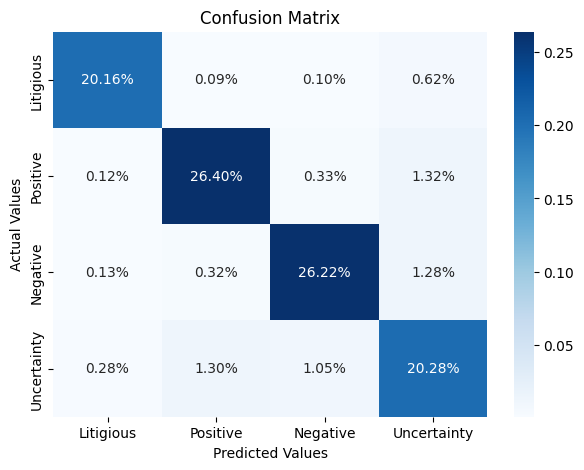


Gaussian Naive Bayes
Recall: 53.5914
Accuracy: 53.5914
F1-Score: 53.3470
Precision: 62.8135

Classification Report

              precision    recall  f1-score   support

   litigious       0.64      0.73      0.68      1950
    positive       0.71      0.42      0.53      2620
    negative       0.75      0.33      0.46      2599
 uncertainty       0.36      0.74      0.49      2131

    accuracy                           0.54      9300
   macro avg       0.62      0.56      0.54      9300
weighted avg       0.63      0.54      0.53      9300



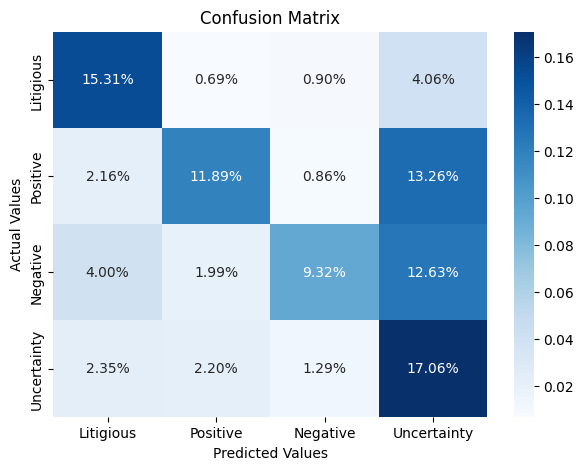


Logistic Regression
Recall: 94.1935
Accuracy: 94.1935
F1-Score: 94.2267
Precision: 94.2864

Classification Report

              precision    recall  f1-score   support

   litigious       0.98      0.96      0.97      1950
    positive       0.95      0.94      0.95      2620
    negative       0.96      0.95      0.95      2599
 uncertainty       0.88      0.91      0.89      2131

    accuracy                           0.94      9300
   macro avg       0.94      0.94      0.94      9300
weighted avg       0.94      0.94      0.94      9300



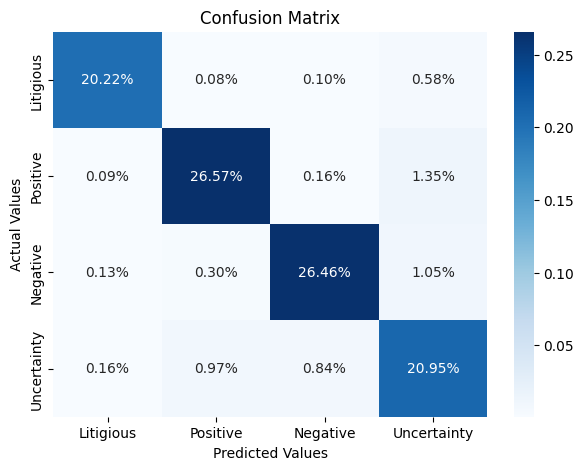


Random Forest Classifier
Recall: 94.6989
Accuracy: 94.6989
F1-Score: 94.6929
Precision: 94.6905

Classification Report

              precision    recall  f1-score   support

   litigious       0.98      0.97      0.97      1950
    positive       0.95      0.95      0.95      2620
    negative       0.96      0.97      0.96      2599
 uncertainty       0.91      0.90      0.90      2131

    accuracy                           0.95      9300
   macro avg       0.95      0.95      0.95      9300
weighted avg       0.95      0.95      0.95      9300



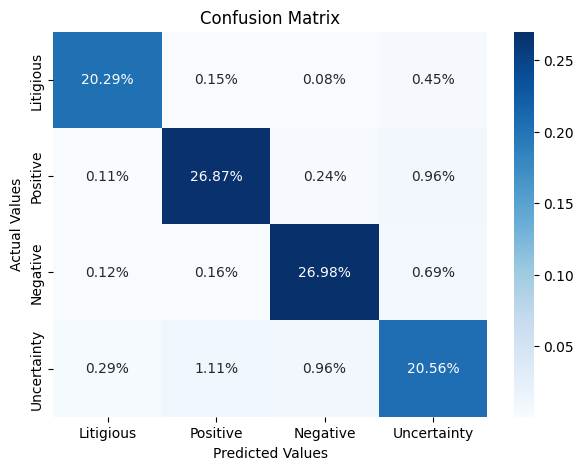



Features Extracted Using Tf-IDF Vectorizer

Linear Support Vector Classification
Recall: 93.8280
Accuracy: 93.8280
F1-Score: 93.8428
Precision: 93.8625

Classification Report

              precision    recall  f1-score   support

   litigious       0.98      0.97      0.97      1950
    positive       0.94      0.94      0.94      2620
    negative       0.95      0.95      0.95      2599
 uncertainty       0.88      0.90      0.89      2131

    accuracy                           0.94      9300
   macro avg       0.94      0.94      0.94      9300
weighted avg       0.94      0.94      0.94      9300



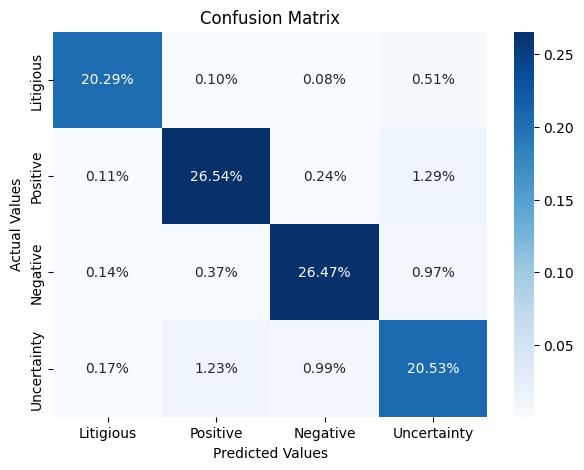


Gaussian Naive Bayes
Recall: 55.7204
Accuracy: 55.7204
F1-Score: 55.5738
Precision: 62.2199

Classification Report

              precision    recall  f1-score   support

   litigious       0.61      0.75      0.67      1950
    positive       0.72      0.51      0.60      2620
    negative       0.72      0.35      0.47      2599
 uncertainty       0.39      0.69      0.50      2131

    accuracy                           0.56      9300
   macro avg       0.61      0.58      0.56      9300
weighted avg       0.62      0.56      0.56      9300



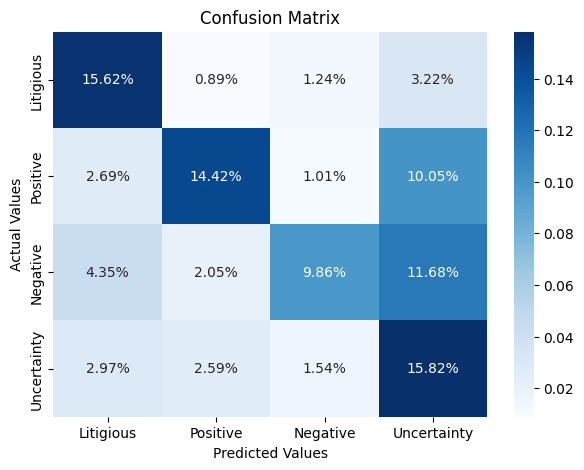


Logistic Regression
Recall: 94.4194
Accuracy: 94.4194
F1-Score: 94.4437
Precision: 94.4863

Classification Report

              precision    recall  f1-score   support

   litigious       0.98      0.96      0.97      1950
    positive       0.95      0.95      0.95      2620
    negative       0.96      0.95      0.96      2599
 uncertainty       0.89      0.92      0.90      2131

    accuracy                           0.94      9300
   macro avg       0.94      0.94      0.94      9300
weighted avg       0.94      0.94      0.94      9300



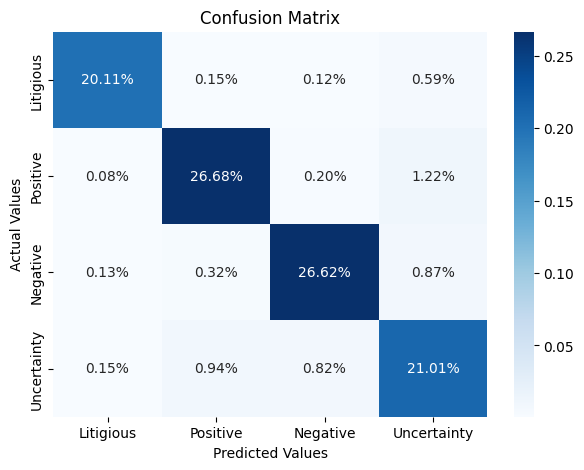


Random Forest Classifier
Recall: 94.9355
Accuracy: 94.9355
F1-Score: 94.9371
Precision: 94.9420

Classification Report

              precision    recall  f1-score   support

   litigious       0.98      0.97      0.98      1950
    positive       0.95      0.95      0.95      2620
    negative       0.96      0.96      0.96      2599
 uncertainty       0.91      0.91      0.91      2131

    accuracy                           0.95      9300
   macro avg       0.95      0.95      0.95      9300
weighted avg       0.95      0.95      0.95      9300



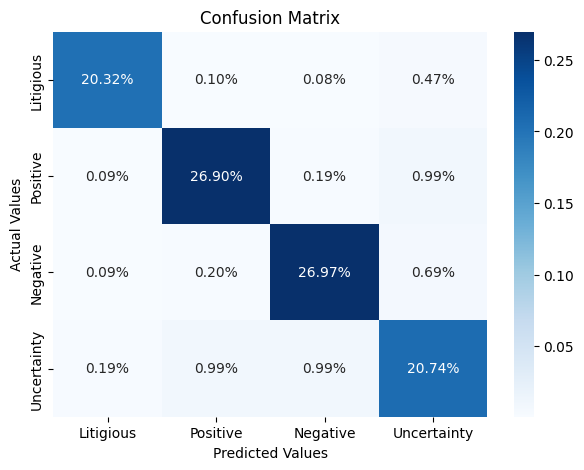

In [42]:
v = vectorizers(df_emoji)

print("\nFeatures Extracted Using Count Vectorizer")
s = split(v[0], v[1])
models(s[0], s[1], s[2], s[3])

print("\n\nFeatures Extracted Using Tf-IDF Vectorizer")
s = split(v[0], v[2])
models(s[0], s[1], s[2], s[3])